In [70]:
import pandas as pd
import numpy as np
import numpy.ma as ma
from numpy import trapz
import math
from scipy.stats import norm
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import statsmodels.api as sm
import pickle
from collections import defaultdict
#import feather
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
with open('./../inds_to_name.pkl','r') as pickleFile:
    inds_to_name = pickle.load(pickleFile)

In [3]:
cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
        'rough375','fairway0','fairway300','fairway540','bunker']
#cats = ['putting','tee','approach','around_green']

In [4]:
# ranks,reps = {},{}
# for cat in cats:
#     try:
#         ranks[cat] = np.load('./../ranks/ranks-30-0.5-0.1-0.9-0.7-10/%s_ranks.npy' % cat)
#         reps[cat] = np.load('./../ranks/ranks-30-0.5-0.1-0.9-0.7-10/%s_reps.npy' % cat)
#     except:
#         continue

In [5]:
with open('./../hole_tups.pkl','r') as pickleFile:
    hole_tups = pickle.load(pickleFile)

In [6]:
bin_size = 4
window_size = 28
# n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups = defaultdict(set)
tournaments = set()
group_to_tups = {}
holes_to_inflate = []
for tup in hole_tups:
    tournaments.add(tuple(tup[0:2]))
    tournament_group = (len(tournaments)-1)/bin_size
    if tournament_group>current_group:
        current_group = tournament_group
        group_to_tups[current_group] = holes_to_inflate
        holes_to_inflate = []
    tournament_groups[current_group+1].add(tuple(tup[0:2]))
    holes_to_inflate.append(tuple(tup))

In [7]:
year_inds = [max([[i[0] for i in tournament_groups[j]]]) for j in tournament_groups]
from collections import Counter
year_inds = [Counter(i) for i in year_inds]
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2017)]

In [8]:
ranks['green0'].shape

NameError: name 'ranks' is not defined

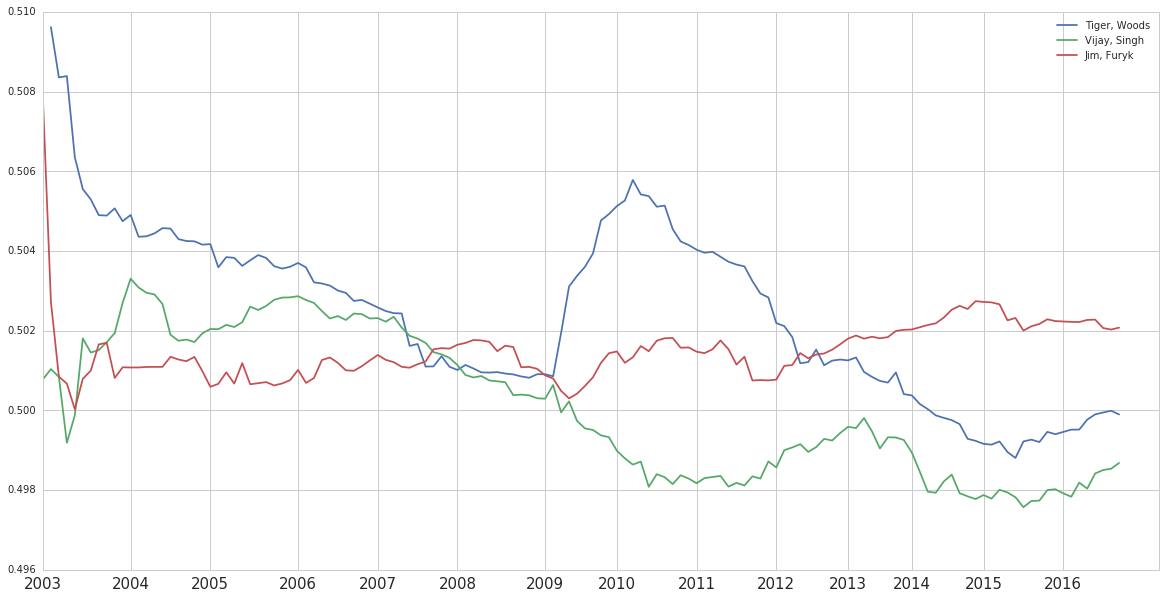

In [16]:
names_to_ind = {value:key for key,value in inds_to_name.iteritems()}
# inds_to_plot = [names_to_ind['Vijay, Singh'],names_to_ind['Tiger, Woods'],names_to_ind['Luke, Donald'],
#                 names_to_ind['Phil, Mickelson'],names_to_ind['Steve, Stricker'],names_to_ind['Jim, Furyk']]
inds_to_plot = [names_to_ind['Tiger, Woods'],names_to_ind['Vijay, Singh'],names_to_ind['Jim, Furyk']]#,
                #names_to_ind['Dustin, Johnson'],names_to_ind['Steve, Stricker'],
                #names_to_ind['Jordan, Spieth'], names_to_ind['Jason, Day']]
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    #area = trapz(y[np.logical_not(np.isnan(y))], dx=5)
    y = [ranks['green0'][j,i] for i in range(ranks['green0'].shape[1])]
    plt.plot(y,label = inds_to_name[j]);
ax.xaxis.set_ticks([i[1] for i in year_inds])
labels = [i[0] for i in year_inds]
ax.set_xticklabels(labels,fontsize=15);
plt.legend();

In [9]:
with open('./../num_to_ind.pkl','r') as pickleFile:
    num_to_ind = pickle.load(pickleFile)

In [10]:
data = pd.read_csv('./../data/round.csv')
data.insert(5,'Player_Index',[num_to_ind[num] if num in num_to_ind else np.nan for num in data.Player_Number])
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])
n_players = len(num_to_ind)

In [11]:
def take_weighted_ave(A,beta):
    A[np.isnan(A)] = 0
    A_ = ma.array(A)
    A_[A_==0] = ma.masked
    M = np.array([[my_norm(j,beta)]*A.shape[0] for j in range(A.shape[1])[::-1]]).T
    M_ = ma.array(M)
    M_[A_==0] = ma.masked
    return np.array(np.multiply(M_,A_).sum(1)/M_.sum(1))

In [158]:
d = {'Player_Index':[],'Permanent_Tournament_#':[],'Finishing_Pct':[]}
d.update({'Field_Strength_%s' % cat:[] for cat in cats})
d.update({'Rating_%s' % cat:[] for cat in cats})
d.update({'Reps_%s' % cat:[] for cat in cats})
d.update({'Pct_Reps_%s' % cat:[] for cat in cats})
master_df = pd.DataFrame(d)
for j in range(ranks['green0'].shape[1]):
    d = {'rank_%s' % cat: ranks[cat][:,j] for cat in cats}
    d.update({'reps_%s' % cat: take_weighted_ave(broadie_opps[cat][:,:j+1],10) for cat in cats})
    df = pd.DataFrame(d).dropna()
    pct_reps,rank_dict,reps_dict,pct_reps_dict = {},{},{},{}
    for cat in cats:
        pct_reps[cat] = pd.Series(df['reps_%s' % cat][df['reps_%s' % cat]!=0]).rank(pct=True)
        df.insert(len(df.columns),'pct_reps_%s' % cat,[0]*len(df))
        df.ix[df['reps_%s' % cat]!=0,'pct_reps_%s' % cat] = pct_reps[cat]
        rank_dict[cat] = df['rank_%s' % cat].to_dict()
        reps_dict[cat] = df['reps_%s' % cat].to_dict()
        pct_reps_dict[cat] = df['pct_reps_%s' % cat].to_dict()
    mask = np.array([False]*len(data))
    for year,t_id in tournament_groups[j+2]:
        mask = np.logical_or(mask,np.logical_and((data['Tournament_Year']==year).values,(data['Permanent_Tournament_#']==t_id).values))
    df2 = data[mask]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Tournament_Year'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    assert len(df3)==len(df3.drop_duplicates(['Player_Index','Permanent_Tournament_#','Tournament_Year']))
    for cat in cats:
        df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3['Reps_%s' % cat] = df3['Player_Index'].map(reps_dict[cat])
        df3['Pct_Reps_%s' % cat] = df3['Player_Index'].map(pct_reps_dict[cat])
    df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in cats]).T.sum(1)==len(cats)].dropna()
    assert len(df3)==len(df3.drop_duplicates(['Player_Index','Permanent_Tournament_#','Tournament_Year']))
    tourn_strength_dict = {}
    tourn_reps_dict = {}
    for cat in cats:
        tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
        df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
        tourn_reps_dict[cat] = df3.groupby('Permanent_Tournament_#')['Reps_%s' % cat].mean().to_dict()
        df3['Field_Reps_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_reps_dict[cat])
    assert len(df3)==len(df3.drop_duplicates(['Player_Index','Permanent_Tournament_#','Tournament_Year']))
    master_df = pd.concat([master_df,df3])

In [159]:
master_df.shape

(67053, 69)

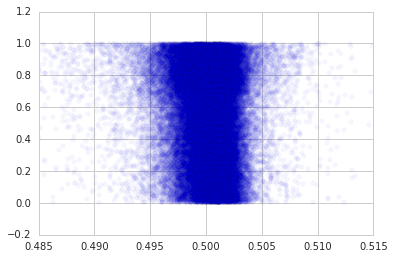

In [160]:
plt.scatter(master_df['Rating_%s' % ('green0',)],master_df.Finishing_Pct,alpha=.04);
plt.xlim(.485,.515);

In [161]:
np.corrcoef(master_df['Rating_%s' % ('green0',)],master_df.Finishing_Pct)

array([[ 1.        , -0.08253017],
       [-0.08253017,  1.        ]])

In [162]:
np.corrcoef(master_df['Rating_%s' % ('green0',)]-master_df['Field_Strength_%s' % ('green0',)],master_df.Finishing_Pct)

array([[ 1.        , -0.08048184],
       [-0.08048184,  1.        ]])

In [163]:
for cat in cats:
    print cat,np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1]

tee3 -0.171065883253
tee45 -0.185922709222
green0 -0.0825301697983
green5 -0.0477884351737
green10 -0.0577732480452
green20 -0.0743505518925
rough0 -0.0801254497679
rough90 -0.0721888775975
rough375 -0.130918669903
fairway0 -0.0998130586251
fairway300 -0.162514362767
fairway540 -0.150124631596
bunker -0.089944614904


In [ ]:
print np.corrcoef(master_df[['Reps_%s' % cat for cat in cats]].values.mean(1),master_df.Finishing_Pct)[0,1]
print np.corrcoef(master_df_broadie[['Reps_%s' % cat for cat in cats]].values.mean(1),master_df_broadie.Finishing_Pct)[0,1]

In [164]:
train = (master_df.Tournament_Year<2013).values

In [166]:
#X_lab = np.array(cats)[np.argsort([np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1] for cat in cats])]
X = master_df[['Rating_%s' % (cat,) for cat in cats]].values - master_df[['Field_Strength_%s' % (cat,) for cat in cats]].values
X = np.hstack((X,(master_df[['Reps_%s' % cat for cat in cats]].values.mean(1)-master_df[['Field_Reps_%s' % (cat,) for cat in cats]].values.mean(1))[:,None]))
#X = sm.add_constant(X)

In [168]:
y = master_df.Finishing_Pct.values

In [169]:
X_train,X_test,y_train,y_test = X[train],X[~train],y[train],y[~train]

In [ ]:
# X_train = pd.DataFrame(X_train)
# X_train.columns = ['coef']+cats#+['reps']
# model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
# results = model.fit()

In [ ]:
# feather.write_dataframe(X, './../adam_df.feather')

In [ ]:
to_predict = set(tuple(tup) for tup in master_df[['Permanent_Tournament_#','Player_Index','Tournament_Year']].values.tolist())

In [ ]:
print results.summary()

In [ ]:
plt.scatter(range(len(master_df)),np.sort(results.predict(X)),alpha=.01);

In [ ]:
np.mean((results.predict(X_test)-y_test)**2)

In [ ]:
np.corrcoef((results.predict(X_test)-y_test)**2,X_test[:,-1])

In [134]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.01, n_estimators=10750, subsample=.5,
                                min_samples_split=2, min_samples_leaf=1, max_depth=3, max_features=4, verbose=0)

In [135]:
def make_monitor(running_mean_len):
    def monitor(i,self,args):
        if np.mean(self.oob_improvement_[max(0,i-running_mean_len+1):i+1])<0:
            return True
        else:
            return False
    return monitor

In [139]:
errors = []
num_estimators = []
stopping_num = range(1,1000,200)
for running_mean_len in stopping_num:
    monitor = make_monitor(running_mean_len)
    gbr.fit(X_train,y_train,monitor=monitor)
    num_estimators.append(gbr.estimators_.shape[0])
    print running_mean_len,gbr.estimators_.shape[0]
    errors.append(np.mean((gbr.predict(X_test) - y_test)**2))

1 587
201 936
401 1090
601 1227
801 1364


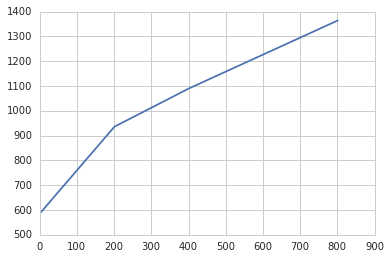

In [140]:
plt.plot(stopping_num,num_estimators);

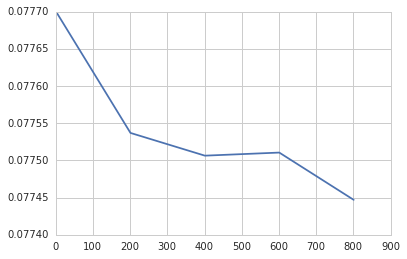

In [141]:
plt.plot(stopping_num,errors);

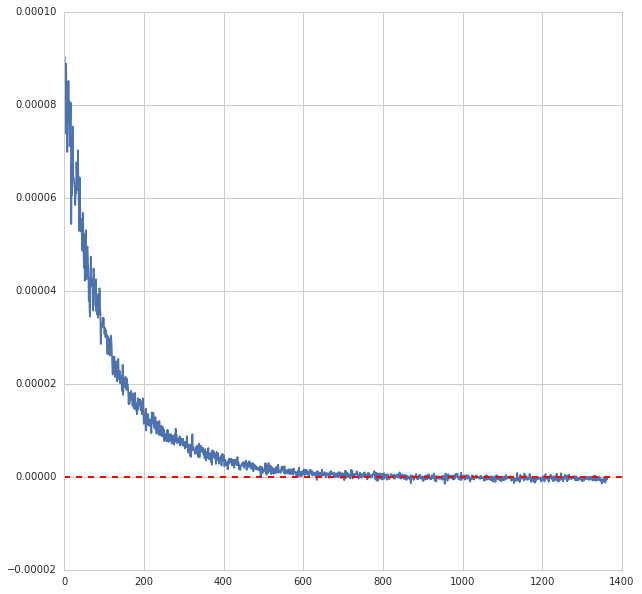

In [142]:
plt.figure(figsize=(10,10))
plt.plot(range(gbr.estimators_.shape[0]),gbr.oob_improvement_)
plt.axhline(0,lw=2,ls='--',c='r');

In [107]:
gbr.feature_importances_

array([ 0.0725219 ,  0.15250034,  0.07578977,  0.05040343,  0.05901873,
        0.05793608,  0.05446399,  0.04623043,  0.05986364,  0.06656072,
        0.08813654,  0.06569206,  0.06806106,  0.0828213 ])

In [108]:
X_train.shape

(49302, 14)

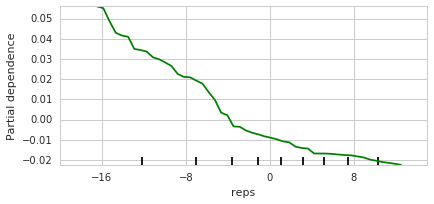

In [109]:
fig,axs = plot_partial_dependence(gbr,X_train,[13],feature_names=np.array(cats+['reps']),n_jobs=1,grid_resolution=50)

In [143]:
labels = cats+['reps']
d = {label:imp for label,imp in zip(labels,gbr.feature_importances_)}
for label in sorted(d,key=d.get,reverse=True):
    print label,d[label]

tee45 0.134412039951
fairway300 0.0885320975991
reps 0.086126150181
green0 0.0720100986657
bunker 0.0701578316389
tee3 0.0675986856816
fairway540 0.0675510998702
fairway0 0.0671178711547
rough375 0.0635953231172
green20 0.0617963728761
green10 0.0593038881548
rough0 0.0579851226685
green5 0.0534797087892
rough90 0.0503337096524


In [144]:
np.mean((gbr.predict(X_test)-y_test)**2)

0.077447001074113633

In [149]:
master_df.shape

(59950, 31)

In [150]:
X.shape

(67053, 14)

In [170]:
master_df.insert(len(master_df.columns),'Predicted_Finishing_Pct',gbr.predict(X))
# master_df.insert(len(master_df.columns),'Var_of_Pred_Finishing_Pct',1/w)
master_df.insert(len(master_df.columns),'Player_Name',[inds_to_name[ind] for ind in master_df.Player_Index])
master_df = master_df.reset_index()

In [171]:
master_df.insert(len(master_df.columns),'Squared_Error',
                 (master_df.Predicted_Finishing_Pct - master_df.Finishing_Pct)**2)

In [172]:
master_df.insert(len(master_df.columns),'Ave_Reps',master_df[['Reps_%s' % cat for cat in cats]].values.mean(1))

In [173]:
master_df.sort_values('Predicted_Finishing_Pct',ascending=True)[['Player_Name','Player_Index','Predicted_Finishing_Pct',
                                                                 'Finishing_Pct','Tournament_Year']].head(10)

,Player_Name,Player_Index,Predicted_Finishing_Pct,Finishing_Pct,Tournament_Year
7597,"Vijay, Singh",80,0.131173,0.045964,2004
2663,"Tiger, Woods",78,0.135565,0.028539,2003
4936,"Vijay, Singh",80,0.142302,0.004153,2004
3162,"Vijay, Singh",80,0.147300,0.051907,2003
2146,"Vijay, Singh",80,0.151530,0.095291,2003
2145,"Vijay, Singh",80,0.154582,0.168502,2003
8644,"Vijay, Singh",80,0.154647,0.005531,2004
6548,"Tiger, Woods",78,0.155896,0.039700,2004
10065,"Vijay, Singh",80,0.156492,0.229167,2005
13244,"Tiger, Woods",78,0.162197,0.018162,2005


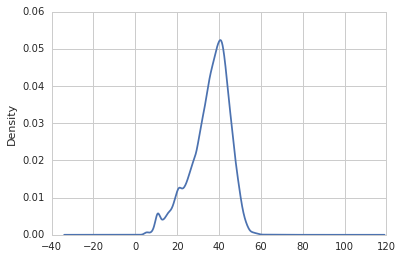

In [51]:
master_df.Ave_Reps.plot(kind='kde');

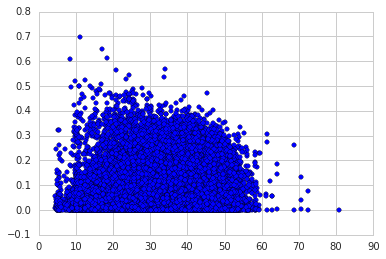

In [62]:
plt.scatter(master_df.Ave_Reps.values,master_df.Squared_Error);

In [116]:
np.corrcoef(master_df.Ave_Reps.values,master_df.Squared_Error)[0,1]

0.085064495886594427

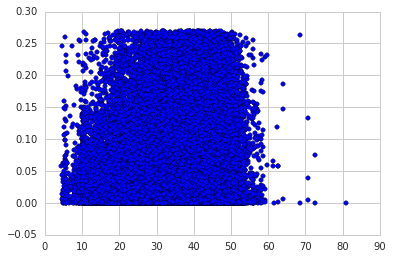

In [57]:
plt.scatter(master_df[master_df.Squared_Error<.27].Ave_Reps.values,master_df[master_df.Squared_Error<.27].Squared_Error);

In [56]:
np.corrcoef(master_df[master_df.Squared_Error<.27].Ave_Reps.values,master_df[master_df.Squared_Error<.27].Squared_Error)[0,1]

0.13602986865048541

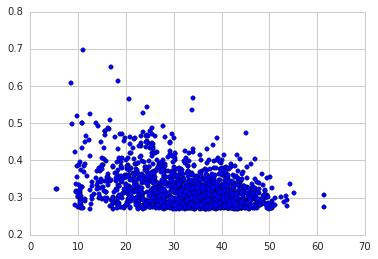

In [58]:
plt.scatter(master_df[master_df.Squared_Error>.27].Ave_Reps.values,master_df[master_df.Squared_Error>.27].Squared_Error);

In [59]:
(master_df.Squared_Error>.27).sum()

1543

In [55]:
np.corrcoef(master_df[master_df.Squared_Error>.27].Ave_Reps.values,master_df[master_df.Squared_Error>.27].Squared_Error)[0,1]

-0.36416576218530516

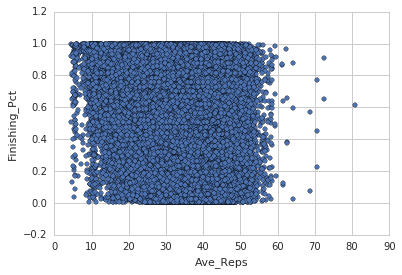

In [64]:
master_df.plot('Ave_Reps','Finishing_Pct',kind='scatter');
#plt.xlim(-.05,1)

In [61]:
np.corrcoef(master_df.Ave_Reps.values,master_df.Finishing_Pct)[0,1]

-0.17267547172472653

Broadie aves

In [ ]:
broadie_cats = cats#['Putting','Off-the-Tee','Approach-the-Green','Around-the-Green']

In [18]:
broadie_aves,broadie_opps = {},{}
for cat in cats:
    broadie_aves[cat] = np.load('./../Broadie_aveso/%s_ave.npy' % cat)
    broadie_opps[cat] = np.load('./../Broadie_aveso/%s_count.npy' % cat)

In [ ]:
names_to_ind = {value:key for key,value in inds_to_name.iteritems()}
# inds_to_plot = [names_to_ind['Vijay, Singh'],names_to_ind['Tiger, Woods'],names_to_ind['Luke, Donald'],
#                 names_to_ind['Phil, Mickelson'],names_to_ind['Steve, Stricker'],names_to_ind['Jim, Furyk']]
inds_to_plot = [names_to_ind['Tiger, Woods'],names_to_ind['Vijay, Singh'],names_to_ind['Jason, Day']]#,
                #names_to_ind['Dustin, Johnson'],names_to_ind['Steve, Stricker'],
                #names_to_ind['Jordan, Spieth'], names_to_ind['Jason, Day']]
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    #area = trapz(y[np.logical_not(np.isnan(y))], dx=5)
    y = [ra[i][j] for i in range(broadie_aves['green0'].shape[1])]
    plt.plot(y,label = inds_to_name[j]);
ax.xaxis.set_ticks([i[1] for i in year_inds])
labels = [i[0] for i in year_inds]
ax.set_xticklabels(labels,fontsize=15);
plt.legend();
#plt.ylim(-.015,.025);

In [12]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [ ]:
beta = 11
d = {'Player_Index':[],'Permanent_Tournament_#':[],'Finishing_Pct':[]}
d.update({'Field_Strength_%s' % cat:[] for cat in broadie_cats})
d.update({'Rating_%s' % cat:[] for cat in broadie_cats})
d.update({'Reps_%s' % cat:[] for cat in broadie_cats})
d.update({'Pct_Reps_%s' % cat:[] for cat in broadie_cats})
master_df_broadie = pd.DataFrame(d)
broadie_ranks,broadie_reps = {},{}
ra,re = [],[]
for j in range(broadie_aves['green0'].shape[1]):
    for cat in broadie_cats:
        if cat not in broadie_ranks:
            broadie_ranks[cat],broadie_reps[cat] = None,None
        broadie_ranks[cat] = take_weighted_ave(broadie_aves[cat][:,:j+1],beta)
        broadie_reps[cat] = take_weighted_ave(broadie_opps[cat][:,:j+1],beta)
        if cat=='tee45':
            ra.append(broadie_ranks[cat])
            re.append(broadie_reps[cat])
    d = {'rank_%s' % cat: broadie_ranks[cat] for cat in broadie_cats}
    d.update({'reps_%s' % cat: broadie_reps[cat] for cat in broadie_cats})
    df = pd.DataFrame(d).dropna()
    pct_reps,rank_dict,reps_dict,pct_reps_dict = {},{},{},{}
    for cat in broadie_cats:
        pct_reps[cat] = pd.Series(df['reps_%s' % cat][df['reps_%s' % cat]!=0]).rank(pct=True)
        df.insert(len(df.columns),'pct_reps_%s' % cat,[0]*len(df))
        df.ix[df['reps_%s' % cat]!=0,'pct_reps_%s' % cat] = pct_reps[cat]
        rank_dict[cat] = df['rank_%s' % cat].to_dict()
        reps_dict[cat] = df['reps_%s' % cat].to_dict()
        pct_reps_dict[cat] = df['pct_reps_%s' % cat].to_dict()
    mask = np.array([False]*len(data))
    for year,t_id in tournament_groups[j+2]:
        mask = np.logical_or(mask,np.logical_and((data['Tournament_Year']==year).values,(data['Permanent_Tournament_#']==t_id).values))
    df2 = data[mask]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Tournament_Year'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    for cat in broadie_cats:
        df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3['Reps_%s' % cat] = df3['Player_Index'].map(reps_dict[cat])
        df3['Pct_Reps_%s' % cat] = df3['Player_Index'].map(pct_reps_dict[cat])
    df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in broadie_cats]).T.sum(1)==len(cats)].dropna()
    tourn_strength_dict = {}
    for cat in broadie_cats:
        tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
        df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
    master_df_broadie = pd.concat([master_df_broadie,df3])

In [ ]:
# errors = []
# for beta in np.arange(3,15,1):
#     errors.append(run(beta))

In [ ]:
plt.plot(np.arange(3,15,1),errors);

In [ ]:
np.arange(3,15,1)[np.argsort(errors)[0]]

In [ ]:
isin = [tuple(tup) in to_predict for tup in master_df_broadie[['Permanent_Tournament_#','Player_Index','Tournament_Year']].values.tolist()]

In [ ]:
master_df_broadie = master_df_broadie[isin]

In [ ]:
X = master_df_broadie[['Rating_%s' % (cat,) for cat in broadie_cats]].values - master_df_broadie[['Field_Strength_%s' % (cat,) for cat in broadie_cats]].values
X = np.hstack((X,master_df_broadie[['Reps_%s' % cat for cat in broadie_cats]].values.mean(1)[:,None]))
X = sm.add_constant(X)
y = master_df_broadie.Finishing_Pct.values

In [ ]:
train = (master_df_broadie.Tournament_Year<2013).values

In [ ]:
X_train,X_test,y_train,y_test = X[train],X[~train],y[train],y[~train]

In [ ]:
X_train = pd.DataFrame(X_train)
X_train.columns = ['coef']+broadie_cats+['reps']
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()

In [ ]:
# feather.write_dataframe(X, './../broadie_df.feather')

In [ ]:
print results.summary()

In [ ]:
np.mean((results.predict(X_test)-y_test)**2)

In [ ]:
np.corrcoef((results.predict(X_test)-y_test)**2,X_test[:,-1])

In [ ]:
improve = []
for cat in cats:
    print cat,np.corrcoef((master_df['Rating_%s' % cat]-master_df['Field_Strength_%s' % (cat,)]).values,master_df.Finishing_Pct)[0,1],\
    np.corrcoef((master_df_broadie['Rating_%s' % cat]-master_df_broadie['Field_Strength_%s' % (cat,)]).values,master_df_broadie.Finishing_Pct)[0,1]
    improve.append((np.corrcoef((master_df_broadie['Rating_%s' % cat]-master_df_broadie['Field_Strength_%s' % (cat,)]).values,master_df_broadie.Finishing_Pct)[0,1]-\
                   np.corrcoef(master_df['Rating_%s' % cat]-master_df['Field_Strength_%s' % (cat,)],master_df.Finishing_Pct)[0,1])/\
                   np.abs(np.corrcoef(master_df_broadie['Rating_%s' % cat]-master_df_broadie['Field_Strength_%s' % (cat,)],master_df_broadie.Finishing_Pct)[0,1]))
#print 'reps',np.corrcoef(master_df[['Reps_%s' % cat for cat in cats]].values.mean(1),master_df.Finishing_Pct)[0,1],np.corrcoef(master_df_broadie[['Reps_%s' % cat for cat in cats]].values.mean(1),master_df_broadie.Finishing_Pct)[0,1]

In [ ]:
# master_df.to_csv('master_df.csv',index=False)
# master_df_broadie.to_csv('master_df_broadie',index=False)

In [ ]:
np.mean(improve)

In [117]:
ranks = {}
scores = {}
for (_, dirnames, _) in os.walk('./../ranks/'):
    for dirname in dirnames:
        for cat in cats:
            try:
                ranks[cat] = np.load('./../ranks/'+dirname+'/%s_ranks.npy' % (cat,))
            except:
                break
        if cat!='bunker':
            continue
        d = {'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Finishing_Pct':[]}
        d.update({'Field_Strength_%s' % cat:[] for cat in cats})
        d.update({'Rating_%s' % cat:[] for cat in cats})
        master_df = pd.DataFrame(d)
        for j in range(ranks['green0'].shape[1]):
            d = {'rank_%s' % cat: ranks[cat][:,j] for cat in cats}
            df = pd.DataFrame(d).dropna()
            rank_dict = {}
            for cat in cats:
                rank_dict[cat] = df['rank_%s' % cat].to_dict()
            mask = np.array([False]*len(data))
            for year,t_id in tournament_groups[j+2]:
                mask = np.logical_or(mask,np.logical_and((data['Tournament_Year']==year).values,(data['Permanent_Tournament_#']==t_id).values))
            df2 = data[mask]
            grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#','Tournament_Year'],as_index=False)
            df3 = grouped['Finishing_Pct'].mean()
            for cat in cats:
                df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
            df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in cats]).T.sum(1)==len(cats)].dropna()
            tourn_strength_dict = {}
            for cat in cats:
                tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
                df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
            master_df = pd.concat([master_df,df3])
        master_df = master_df[master_df.Tournament_Year<2013]
        scores[dirname] = {}
        for cat in cats:
            scores[dirname][cat] = np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1]

In [175]:
for cat in cats:
    print cat
    d = {key:scores[key][cat] for key in scores.keys()}
    for key in sorted(d,key=d.get)[0:3]:
        print key,d[key]
    best = sorted(d,key=d.get)[0]
    ranks[cat] = np.load('./../ranks/'+best+'/%s_ranks.npy' % (cat,))
    #reps[cat] = np.load('./../ranks/'+best+'/%s_reps.npy' % (cat,))

tee3
ranks-300-0.01-0.01-0.3-0.99-13 -0.163647171391
ranks-300-0.01-0.01-0.7-0.99-13 -0.163632861683
ranks-150-0.5-0.25-0.8-0.95-12 -0.163517821624
tee45
ranks-300-0.01-0.01-0.3-0.99-5 -0.176155396279
ranks-300-0.01-0.01-0.7-0.99-5 -0.17614556336
ranks-300-0.01-0.01-0.3-0.93-5 -0.174038579435
green0
ranks-300-0.01-0.01-0.3-0.99-17 -0.0904831822112
ranks-300-0.01-0.01-0.3-0.99-13 -0.0904008858706
ranks-300-0.01-0.01-0.7-0.99-13 -0.0903949668044
green5
ranks-200-0.4-0.2-0.75-0.97-17 -0.0427270127297
ranks-200-0.4-0.2-0.75-0.97-10 -0.0424014901266
ranks-200-0.4-0.2-0.75-0.86-15 -0.0420891088685
green10
ranks-300-0.01-0.01-0.3-0.99-9 -0.0531038504557
ranks-300-0.01-0.01-0.7-0.99-9 -0.0530741122557
ranks-300-0.01-0.01-0.3-0.93-9 -0.0526294753514
green20
ranks-120-0.6-0.25-0.8-0.93-10 -0.066589306557
ranks-150-0.5-0.25-0.8-0.95-10 -0.0663927969504
ranks-150-0.5-0.25-0.8-0.95-12 -0.0658404900386
rough0
ranks-300-0.01-0.01-0.3-0.99-17 -0.0842649694108
ranks-300-0.01-0.01-0.7-0.99-13 -0.0840041

In [ ]:
corrs=defaultdict(list)
for year in range(2003,2017):
    d = {'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Finishing_Pct':[]}
    d.update({'Field_Strength_%s' % cat:[] for cat in cats})
    d.update({'Rating_%s' % cat:[] for cat in cats})
    master_df = pd.DataFrame(d)
    for j in range(ranks['green0'].shape[1]):
        d = {'rank_%s' % cat: ranks[cat][:,j] for cat in cats}
        df = pd.DataFrame(d).dropna()
        rank_dict = {}
        for cat in cats:
            rank_dict[cat] = df['rank_%s' % cat].to_dict()
        years = [i[0] for i in tournament_groups[j+2]]
        t_ids = [i[1] for i in tournament_groups[j+2]]
        df2 = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
        grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#','Tournament_Year'],as_index=False)
        df3 = grouped['Finishing_Pct'].mean()
        for cat in cats:
            df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in cats]).T.sum(1)==len(cats)].dropna()
        tourn_strength_dict = {}
        for cat in cats:
            tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
            df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
        master_df = pd.concat([master_df,df3])
    master_df = master_df[master_df.Tournament_Year==year]
    for cat in cats:
        corrs[cat].append(np.corrcoef(master_df['Rating_%s' % (cat,)].values - master_df['Field_Strength_%s' % (cat,)].values,\
                          master_df.Finishing_Pct)[0,1])

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
for cat in cats:
    plt.plot(range(2003,2017),corrs[cat],label=cat)
plt.legend();

In [ ]:
def make_natural_spline_matrix(x,df):
    t = np.percentile(x,np.linspace(0,100,df+2)[1:-1])
    print t
    X = np.column_stack(([1.0]*len(x),x))
    def d(x,e_k,e_K):
        def pos(x,e):
            x_ = np.copy(x)
            x_[x<=e] = 0.0
            x_[x>e] = (x_[x>e]-e)**3
            return x_
        return (pos(np.copy(x),e_k) - pos(np.copy(x),e_K))/(e_K-e_k)
    for k in range(1,len(t)-1):
        X = np.column_stack((X,d(np.copy(x),t[k],t[-1]) - d(np.copy(x),t[k-1],t[-1])))
    return X